In [127]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from feature_extraction import graph_feature_extraction, seg_feature_extraction
from loader import hetero_graph_loader
from utils import prep
from matplotlib import pyplot as plt
import numpy as np
import torch 
import pandas as pd
from evaluation import evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 1, "Early NPDR": 2, "Late NPDR": 2}

vessel_graph_path = "/media/data/alex_johannes/octa_data/Cairo/SCP_vessel_graph"
void_graph_path = "/media/data/alex_johannes/octa_data/Cairo/SCP_void_graph"
hetero_edges_path = "/media/data/alex_johannes/octa_data/Cairo/SCP_heter_edges"


train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "train",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "test",
                                                        label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv", 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)

In [172]:
# do data imputation
prep.hetero_graph_imputation(train_dataset)

# extract graph features
train_g_extractor = graph_feature_extraction.GraphFeatureExtractor(train_dataset.hetero_graphs, mode=torch.mean)
train_g_feature_dict = train_g_extractor.get_feature_dict()

test_g_extractor = graph_feature_extraction.GraphFeatureExtractor(test_dataset.hetero_graphs, mode=torch.mean)
test_g_feature_dict = test_g_extractor.get_feature_dict()

#extract segmentation features
seg_path = "/media/data/alex_johannes/octa_data/Cairo/SCP_seg"
seg_extractor = seg_feature_extraction.SegFeatureExtractor(seg_path)
seg_feature_dict = seg_extractor.get_feature_dict()


In [173]:
res = sorted(list(seg_feature_dict.keys()))
print(res)

seg_feature_dict["0001_OS"]

['0001_OS', '0002_OS', '0003_OD', '0003_OS', '0004_OD', '0004_OS', '0005_OD', '0005_OS', '0006_OD', '0007_OD', '0007_OS', '0008_OS', '0009_OD', '0010_OD', '0011_OD', '0012_OD', '0012_OS', '0013_OD', '0013_OS', '0014_OD', '0015_OD', '0015_OS', '0016_OD', '0016_OS', '0017_OD', '0017_OS', '0018_OD', '0018_OS', '0019_OD', '0019_OS', '0020_OD', '0021_OD', '0021_OS', '0022_OD', '0022_OS', '0023_OS', '0024_OD', '0024_OS', '0025_OD', '0026_OD', '0026_OS', '0027_OD', '0027_OS', '0028_OD', '0029_OD', '0030_OD', '0030_OS', '0031_OD', '0032_OD', '0033_OD', '0034_OD', '0035_OS', '0036_OD', '0036_OS', '0037_OD', '0037_OS', '0038_OD', '0039_OD', '0039_OS', '0040_OS', '0041_OD', '0041_OS', '0042_OD', '0042_OS', '0043_OS', '0044_OD', '0045_OD', '0045_OS', '0046_OD', '0047_OD', '0047_OS', '0048_OS', '0049_OD', '0049_OS', '0050_OD', '0050_OS', '0051_OD', '0051_OS', '0052_OD', '0052_OS', '0053_OS', '0054_OD', '0055_OD', '0055_OS', '0056_OD', '0056_OS', '0057_OD', '0057_OS', '0058_OD', '0059_OS', '0060_OD'

[0.19329174601800553,
 0.19713036703601108,
 0.1936217754501385,
 0.18354776229224376,
 0.19886707929362882]

In [174]:
# combined feature dict

def create_combined_feature_dict(g_feature_dict, seg_feature_dict, dataset):
    comb_feature_dict = {}
    for key, val in g_feature_dict.items():
        comb_feature_dict[key] = (np.concatenate([val["graph_1"],val["graph_2"], seg_feature_dict[key]], axis = 0), int(dataset.hetero_graphs[key].y[0]))
    return comb_feature_dict

In [175]:
train_comb_feature_dict = create_combined_feature_dict(train_g_feature_dict, seg_feature_dict, train_dataset)
test_comb_feature_dict = create_combined_feature_dict(test_g_feature_dict, seg_feature_dict, test_dataset)

In [176]:
x_train = np.array([val[0] for val in train_comb_feature_dict.values()])
y_train = np.array([val[1] for val in train_comb_feature_dict.values()])

x_test = np.array([val[0] for val in test_comb_feature_dict.values()])
y_test = np.array([val[1] for val in test_comb_feature_dict.values()])

In [177]:
x_test.shape

(180, 39)

In [178]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV


param_grid_rf = {'max_depth': [8, 9, 10, 12, 15], 'max_features': ["sqrt", "log2"]}


rf = RandomForestClassifier(class_weight='balanced')
clf_rf = GridSearchCV(rf, param_grid_rf, scoring = "balanced_accuracy")
clf_rf.fit(x_train, y_train)

print(clf_rf.best_score_)
print(clf_rf.best_params_)

rf_best = clf_rf.best_estimator_
rf_best.fit(x_train, y_train)

0.5227292768959436
{'max_depth': 9, 'max_features': 'sqrt'}


RandomForestClassifier(class_weight='balanced', max_depth=9)

In [179]:
"""

importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()"""

'\n\nimportances = rf_best.feature_importances_\nstd = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)\n\nforest_importances = pd.Series(importances)\n\nfig, ax = plt.subplots()\nforest_importances.plot.bar(yerr=std, ax=ax)\nax.set_title("Feature importances using MDI")\nax.set_ylabel("Mean decrease in impurity")\nfig.tight_layout()'

0.8111111111111111
0.6170519787541063


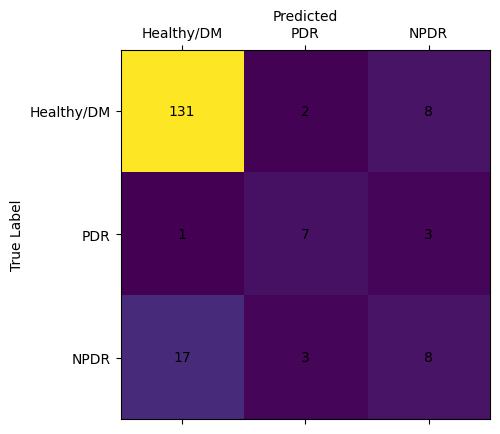

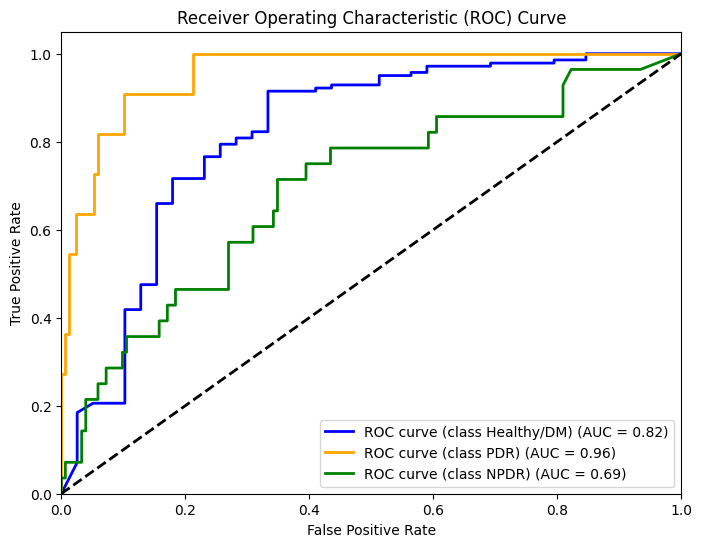

In [180]:
y_p = rf_best.predict(x_test)
print(accuracy_score(y_test, y_p))
print(balanced_accuracy_score(y_test, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_test, y_p, ["Healthy/DM", "PDR", "NPDR"], ax) # , 3, 4
plt.show()
y_prob = rf_best.predict_proba(x_test)
evaluation.plot_roc_curve(y_test, y_prob, class_labels = ["Healthy/DM", "PDR", "NPDR"]) 